In [50]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [51]:
train_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN',
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)


test_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST',
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

In [52]:
label_names = test_dataset.classes

print(label_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [53]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)


test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [54]:
device = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')

In [65]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()


        self.conv1 = nn.Conv2d(3,8,3,padding = 1) # 64*64 -> 
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8,16,3, padding = 1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(16,32,3, padding = 1)
        self.pool3 = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(32,64,5, padding = 2, stride = 1)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64*4*4,256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256,4)


    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        x = x.view(-1,64*4*4)


        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [66]:
model = CNN().to(device)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [67]:
num_epochs = 10

train_losses = []
val_losses = []

In [68]:
epoch_train_loss = 0
epoch_val_loss = 0

for epoch in range(num_epochs):
    model.train()

    running_train_loss = 0.0

    for images, labels in train_dataloader:
        optimizer.zero_grad()
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
        
    epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
    train_losses.append(epoch_train_loss)


    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            outputs = model(images)
            loss = loss_function(outputs,labels)
            running_val_loss += loss.item() * images.size(0)

        epoch_val_loss = running_val_loss / len(test_dataloader.dataset)
        val_losses.append(epoch_val_loss)


    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")



Epoch 1/10 | Train Loss: 1.3570 | Val Loss: 1.3139
Epoch 2/10 | Train Loss: 1.1213 | Val Loss: 0.9344
Epoch 3/10 | Train Loss: 0.9142 | Val Loss: 0.7381
Epoch 4/10 | Train Loss: 0.5474 | Val Loss: 0.3813
Epoch 5/10 | Train Loss: 0.3719 | Val Loss: 0.2956
Epoch 6/10 | Train Loss: 0.2848 | Val Loss: 0.3247
Epoch 7/10 | Train Loss: 0.2256 | Val Loss: 0.2385
Epoch 8/10 | Train Loss: 0.1964 | Val Loss: 0.3006
Epoch 9/10 | Train Loss: 0.1520 | Val Loss: 0.2601
Epoch 10/10 | Train Loss: 0.1248 | Val Loss: 0.3093


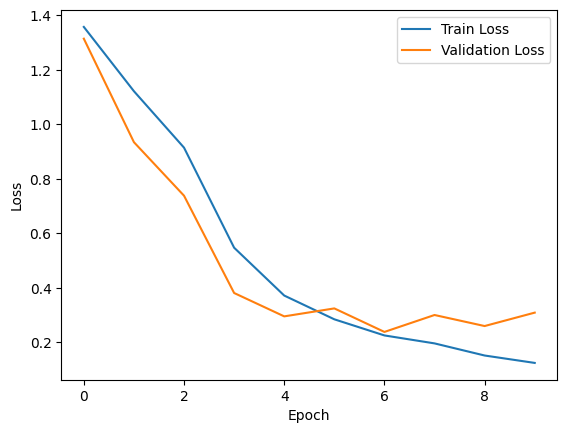

In [69]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
model.eval()

true_labels = []
pred_probs = []


with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model(inputs)
        probs = torch.softmax(logits, dim=1)
        true_labels.extend(labels.tolist())
        pred_probs.extend(probs.tolist())

true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)


acc = accuracy_score(true_labels, np.argmax(pred_probs, axis=1))
f1 = f1_score(true_labels, np.argmax(pred_probs, axis=1), average='macro')
auc = roc_auc_score(true_labels, pred_probs, multi_class='ovo')


print(f'Test accuracy: {acc:.4f}')
print(f'Test F1 score: {f1:.4f}')
print(f'Test AUC score: {auc:.4f}')



Test accuracy: 0.8613
Test F1 score: 0.8639
Test AUC score: 0.9773
